In this notebook, I am going to use data that were cleaned in previous notebooks to build a model for predicting diabetes patients. The datasets to be used contain informations about patients demography, physicians specialties, medical transcripts, and medications.

The process consists in:
1. Loading cleaned data and building one large dataset. containing all information
2. Carrying an exploratory data analysis. I will generate visualization that make it easy to see correlations between independent and dependent variables. In this section, statistical tests will also be used to validate separability of the dependent variable among different groups of the independent variables
3. Building a predictive model. Three different Gradient Boost ML algorithms will be tuned and to optimize the best parameters for final predictions
4. Validating the models


Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA
from pprint import pprint

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### 3. Import data

In [2]:
patients = pd.read_csv('agg_data/patient.csv',index_col='PatientGuid').sort_index()
diagnosis = pd.read_csv('agg_data/diagnosis.csv',index_col='PatientGuid').sort_index()
physicisians = pd.read_csv('agg_data/physician_specialty.csv',index_col='PatientGuid').sort_index()
transcripts = pd.read_csv('agg_data/transcript.csv',index_col='PatientGuid').sort_index()
medications = pd.read_csv('agg_data/medication.csv',index_col='PatientGuid').sort_index()
medications.columns = map(lambda x:'med_'+x,medications.columns)
data = pd.concat([diagnosis,physicisians,transcripts,medications,patients],axis=1)
data.fillna(0,inplace=True)
#create artifical IDs. These will be useful later to keep track of training and validation sets
data['ID'] = range(data.shape[0])
print "size of dataframe:", data.shape

size of dataframe: (9948, 2492)


Separate different independent variables by data types. Set numerical and categorical apart

In [3]:
target = 'DMIndicator'
categorical = ['Gender','State']
categorical += [x for x in data.columns if 'Icd' in x]
categorical += [x for x in data.columns if 'PhySp' in x]
numerical = data[[x for x in data.columns if (x not in categorical)]].columns.tolist()
categorical +=['ID']

### 2. Exploratory data analysis
We start by creating functions to be used to quickly generate visualizations

In [4]:
def hist_numerical(df,col,nbins=10,target='DMIndicator',yscale='linear',normalize=False):
    """
    This function generate histogram of numerical variables
    df (pandas.dataframe): original dataset
    col (str): independent variable to be on x-axis. It has to be a column of df
    nbins (int): number of bins to be created
    target (str): dependent variable. It has to be a column of df
    yscale (str): use either linear for linear scale or log for log scale
    normalize (bool): True - bars are normalized or - not otherwise
    """
    x = df[col]
    hy1,hx1 = np.histogram(df[col][df[target] == 1],bins=nbins,normed=normalize)
    hy2,hx2 = np.histogram(df[col][df[target] == 0],bins=hx1,normed=normalize)
    w = 0.4*(hx1[1] - hx1[0])
    plt.figure(figsize=(5,3))
    plt.bar(hx1[:-1],hy1,width=w,color='blue',edgecolor='none')
    plt.bar(hx2[:-1]+w,hy2,width=w,color='green',edgecolor='none')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.yscale(yscale)
    plt.legend([1,0],title=target)
    print col, stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0])

def bar_categorical(df,col,target='DMIndicator',yscale='linear',normalize=False,title_on=False):
    """
    This function generate histogram of categorical variables
    df (pandas.dataframe): original dataset
    col (str): independent variable to be on x-axis. It has to be a column of df
    target (str): dependent variable. It has to be a column of df
    yscale (str): use either linear for linear scale or log for log scale
    normalize (bool): True - bars are normalized or - not otherwise
    """
    x = pd.concat([df[df[target] == 1][col].value_counts(normalize = normalize),
                   df[df[target] == 0][col].value_counts(normalize = normalize)],axis=1)
    x.columns = [1,0]
    w = 0.4*(x.index[1] - x.index[0])
    plt.bar(x.index,x[1],color='b',width=w)
    plt.bar(x.index+w,x[0],color='g',width=w)
    if col != target: plt.xticks(x.index+w,x.index)
    else:plt.xticks([0.6,1.2],x.index)
    plt.yscale(yscale)
    plt.xlabel(col.split('_')[-1])
    if not normalize:plt.ylabel('Count')
    else:plt.ylabel('Frequency')
    plt.legend([1,0],title=target.split('_')[-1])
    if title_on: plt.title('Distribution of '+col.split('_')[-1])
    x.columns = [target.split('_')[-1]+'_1',target.split('_')[-1]+'_0']
    x.index = map(lambda x:col.split('_')[-1]+'_'+str(x),x.index)
    return x


def box_numerical(df,col,target='DMIndicator',ylim=[0,25]):
    """
    This function generate boxplot of numerical variables
    df (pandas.dataframe): original dataset
    col (str): independent variable to be on x-axis. It has to be a column of df
    target (str): dependent variable. It has to be a column of df
    ylim (list, tuple): set y limits
    """
    plt.figure(figsize=(5,3))
    plt.boxplot([df[col][df[target] == 0],df[col][df[target] == 1]])
    plt.xticks([1,2],[0,1])
    plt.ylim(ylim)
    plt.ylabel(col)
    print col,stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0])

Use above functions to visualize data and run statistical tests

Age Ttest_indResult(statistic=27.859596396767721, pvalue=1.5320221627513069e-164)
BMI_Max Ttest_indResult(statistic=20.782972073699653, pvalue=6.0134387449983657e-94)


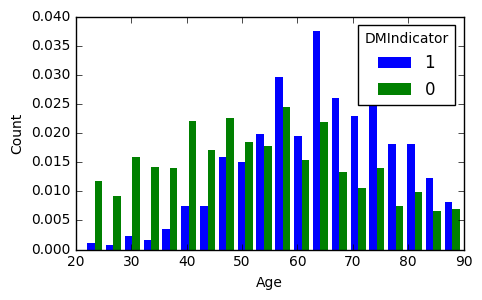

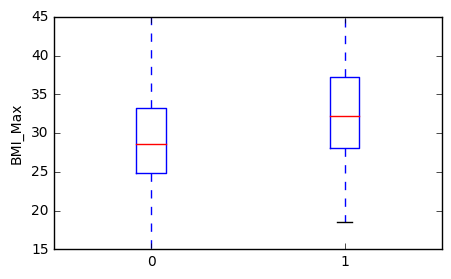

In [5]:
n = 2
#hist_numerical(data,numerical[n],nbins=20,yscale='linear',normalize=False)
hist_numerical(data,'Age',nbins=20,yscale='linear',normalize=True)
#hist_numerical(data,'BMI_Max',nbins=20,yscale='linear',normalize=True)
box_numerical(data,'BMI_Max',ylim=[15,45])
plt.show()
#print numerical[n], n,'/',len(numerical)

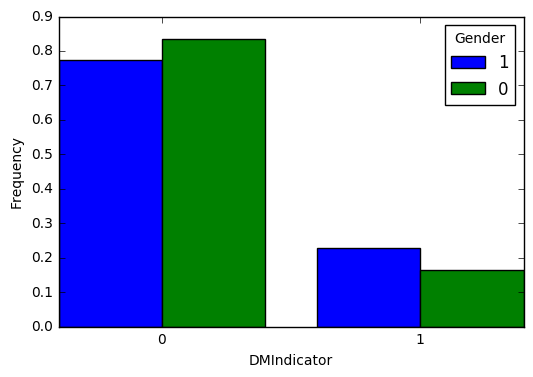

In [6]:
bar_categorical(data,col='DMIndicator',target='Gender',yscale='linear',title_on=False, normalize=True)
plt.show()

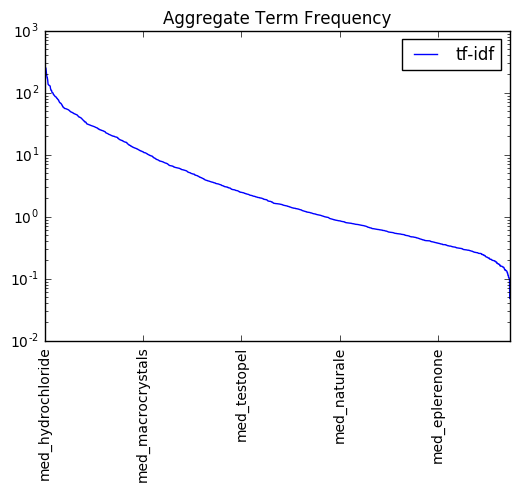

In [7]:
tfidf_agg = medications.sum().sort_values(ascending=False)
d_tfidf_agg = -(tfidf_agg - tfidf_agg.shift())#.sort_values()
tfidf_agg.plot()
#d_tfidf_agg.plot()
plt.yscale('log')
plt.title("Aggregate Term Frequency")
plt.xticks(rotation=90)
plt.legend(['tf-idf','derivative'])
plt.show()

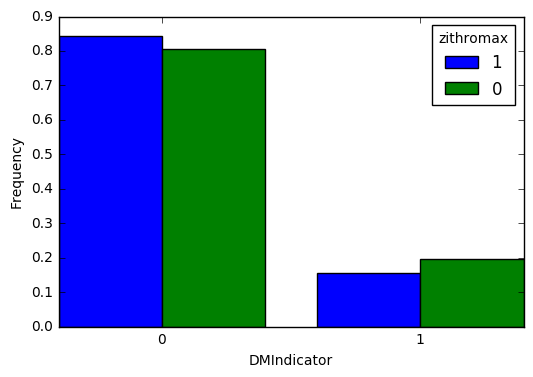

,zithromax_1,zithromax_0
DMIndicator_0,0.844291,0.805198
DMIndicator_1,0.155709,0.194802


In [8]:
highest_lowest_tfidf = tfidf_agg[(tfidf_agg<0.2) | (tfidf_agg>50)].index.tolist()
col = highest_lowest_tfidf[9]
df = 1*(data[[col]+['DMIndicator']]>0)
xx = bar_categorical(df,col='DMIndicator',target=col,normalize=True)
plt.show()
xx

In [9]:
#after having a look at each variable, consider noting down those found not import according to the stat tests
non_important = ['DiagnosisFreq','AcuteCount','Height_Max','Temperature_Max','Weight_Min','BMI_Min',
                 'RespiratoryRate_Min','Temperature_Std','Height_Mean','Height_Change','RespiratoryRate_Change',
                 'Temperature_Change']

### 3. Modeling

We will first prepare different sets of labels as we optimize and cross-validate proposed model. Then, we will split the data into training and validation sets. 

In [10]:
# import scikit learn libraries
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [11]:
# create functions to be used to tune parameters

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' by performing cross-validation. It works on both regression and classification
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cv or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print "\nModel report:"
        if scoring_method == 'roc_auc':
            print "Accuracy:",metrics.accuracy_score(dtrain[target].values,dtrain_predictions)
            print "AUC Score (Train):",metrics.roc_auc_score(dtrain[target], dtrain_predprob)
        if (scoring_method == 'mean_squared_error'):
            print "Accuracy:",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions)
    if performCV:
        print "CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn model,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    train: pandas.DataFrame, training data
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch


In [12]:
#create different sets of labels
labels1 = []
labels2 = numerical[:]
labels2.pop(labels2.index('DMIndicator'))
labels3 = filter(lambda x: not x.startswith('med'),list(set(numerical).difference(set(non_important))))
labels3.pop(labels3.index('DMIndicator'))
labels4 = categorical[:]
labels5 = ['ID','Icd9_390-459', 'State', 'Icd9_240-279', 'PhySp_Internal_Medicine', 'PhySp_Family_Practice', 'PhySp_General_Practice', 'Icd9_780-799', 'PhySp_Unknown', 'Icd9_710-739', 'Icd9_E-V', 'Gender', 'PhySp_Geriatric_Medicine', 'Icd9_290-319', 'PhySp_Podiatry', 'PhySp_Cardiovascular_Disease', 'PhySp_Pulmonary_Disease', 'Icd9_580-629', 'PhySp_Endocrinology__Diabetes__Metabolism', 'PhySp_Adolescent_Medicine', 'PhySp_Nephrology', 'Icd9_280-289', 'Icd9_460-519', 'Icd9_320-359', 'Icd9_680-709', 'Icd9_520-579']
labels6 = filter(lambda x: x.startswith('med'),data.columns)+['ID']
#labels6 = list(set(labels6).difference(set(highest_lowest_tfidf)))

#split data into training and validation sets
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels6],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

labels2.pop(labels2.index('ID'))
labels3.pop(labels3.index('ID'))
labels4.pop(labels4.index('ID'))
labels5.pop(labels5.index('ID'))
labels6.pop(labels6.index('ID'))

'ID'

The next block is for optimizing parameters to tune the model

In [ ]:
gbm1 = GradientBoostingClassifier(
    learning_rate = 0.1,
    min_samples_split=2,
    max_depth=2,
    max_features='auto',
    subsample=0.8,
    random_state = 10
)
train = _Xtrain.copy()
train['DMIndicator'] = _Ytrain
param_test = {'n_estimators':range(10,151,20)} #labels5->range(250,501,20), labels6->range(10,151,20)
predictors = labels6
#train[predictors] = standardize(train[predictors])

# optimize number of trees
gs_cls = optimize_num_trees(gbm1,param_test,'roc_auc',train,predictors,target)
print "Best Parameters:\n\t",gs_cls.best_params_
print "Best Score:\n\t",gs_cls.best_score_
print "Grid Scores:"
pprint(gs_cls.grid_scores_)

# cross validate the best model with optimized number of estimators
alg = modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc',printFeatureImportance=False)

# testing on a different set
ypred = gs_cls.best_estimator_.predict(_Xvalid[predictors])
print "ROC AUC:", metrics.roc_auc_score(ypred,_Yvalid)

Here, we use optimized parameters to make final predictions

In [13]:
# prep training and validation
train = data[data.ID.isin(_train_ids)]
valid = data[data.ID.isin(_valid_ids)]

# set optimized parameters
gbm_num = GradientBoostingClassifier(n_estimators = 90,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_cat = GradientBoostingClassifier(n_estimators = 350,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_med = GradientBoostingClassifier(n_estimators= 150, learning_rate=0.1,
                                     min_samples_split=2, max_depth=2, max_features='auto',
                                     subsample=0.8,random_state = 10)

#train the model
print "Training models"
print "---------------"
print "-- Numerical variables --"
alg_num = modelfit(gbm_num,train,labels3,target,'roc_auc',printFeatureImportance=False)
print "-- Categorical variables --"
alg_cat = modelfit(gbm_cat,train,labels5,target,'roc_auc',printFeatureImportance=False)
print "-- Medication Names --"
alg_med = modelfit(gbm_med,train,labels6,target,'roc_auc',printFeatureImportance=False)

Training models
---------------
-- Numerical variables --

Model report:
Accuracy: 0.826028682482
AUC Score (Train): 0.813151476673
CV Score - Mean : 0.776137 | Std : 0.01331027 | Min : 0.7525612 | Max : 0.7902491
-- Categorical variables --

Model report:
Accuracy: 0.834740651387
AUC Score (Train): 0.82757019937
CV Score - Mean : 0.7743555 | Std : 0.008472267 | Min : 0.7636612 | Max : 0.7896208
-- Medication Names --

Model report:
Accuracy: 0.832462136443
AUC Score (Train): 0.785254077635
CV Score - Mean : 0.7003775 | Std : 0.01785759 | Min : 0.6780997 | Max : 0.7221127


In [14]:
#make predictions
ypred_num = alg_num.predict(valid[labels3])
ypred_cat = alg_cat.predict(valid[labels5])
ypred_med = alg_med.predict(valid[labels6])
ypredprob_num = alg_num.predict_proba(valid[labels3])[:,1]
ypredprob_cat = alg_cat.predict_proba(valid[labels5])[:,1]
ypredprob_med = alg_med.predict_proba(valid[labels6])[:,1]

#create an ensemble of models based of categorical and numerical variables
ypred_combo = ((0.5*ypredprob_num + 0.0*ypredprob_cat +0.5*ypredprob_med)>0.5)*1


print "====== Model validation ======"
print "Summary results"
print "ROC AUC - numerical variables model:", round(metrics.roc_auc_score(ypred_num,valid[target]),3)
print "ROC AUC - categorical variables model:", round(metrics.roc_auc_score(ypred_cat,valid[target]),3)
print "ROC AUC - medication names model:", round(metrics.roc_auc_score(ypred_med,valid[target]),3)
print "ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3)

====== Model validation ======
Summary results
ROC AUC - numerical variables model: 0.707
ROC AUC - categorical variables model: 0.68
ROC AUC - medication names model: 0.736
ROC AUC - ensemble model: 0.81


**Optimize weights for the final ensemble model**

Use a modified Gradient Descent algorithm to find best weights to allocate to each of the three models.

In [15]:
def loss(w,yps):
    yp_combo = ((w[0]*yps[0]+w[1]*yps[1]+w[2]*yps[2])>0.5)*1
    return 1-metrics.roc_auc_score(yp_combo,valid[target])

def dloss(w,yps,learning_rate = 0.0001):
    dw = [metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target])]
    w = [w[i] - (learning_rate*dw[i]) for i in range(len(w))]
    try:
        error = loss(w,yps)
        return [w,error]
    except:
        pass
        return [w,1000]

def optimize(w,yps,learning_rate = 0.0001,n_iters = 1000,plot_error=False):
    r = [w,loss(w,yps)]
    for i in range(n_iters):
        r.append(dloss(r[-1][0],yps,learning_rate=learning_rate))
    if plot_error:
        plt.plot(map(lambda x:x[1],r))
        plt.show()
    return r[-1][0]
#dloss([.5,.2,.3],[ypredprob_num,ypredprob_cat,ypredprob_med], learning_rate=0.01)
#optimize([0.5,.3,.2],[ypredprob_num,ypredprob_cat,ypredprob_med],learning_rate=0.01,plot_error=True)
w0 = [.5,.2,.3]
yps0 = [ypredprob_num,ypredprob_cat,ypredprob_med]
ers = []
ws = []
for i in range(1000):
    w0,er =  dloss(w0,yps0, learning_rate= 0.001)
    ws.append(w0)
    ers.append(er)
#plt.plot(er)
#plt.show()
n = ers.index(min(ers))
w_opt = map(lambda x:round(x,3),ws[n])
print "1 - AUC:",ers[n],"\tweights:",w_opt

print "====== Optimized ensemble model ======"
ypred_combo = ((w_opt[0]*ypredprob_num + w_opt[1]*ypredprob_cat + w_opt[2]*ypredprob_med)>0.5)*1
print "ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3)

1 - AUC: 0.148170567662 	weights: [0.465, 0.165, 0.265]
====== Optimized ensemble model ======
ROC AUC - ensemble model: 0.852
